In [103]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pickle
import os 
from glob import glob
import matplotlib as mpl 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import permutation_test
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from methods import * 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [201]:
data_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
dataset = (
    pd.read_excel(io=data_url, header=1)
    .drop(columns=["ID"])
    .rename(
        columns={"PAY_0": "PAY_1", "default payment next month": "default"}
    )
)

np.random.seed(42)
train_inds = np.random.choice(dataset.shape[0], 10000, replace=False)
df_train = dataset.iloc[train_inds]

X_train = df_train.drop(columns='default')
y_train = df_train['default']

In [202]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
df_test = dataset[~dataset.index.isin(train_inds)]
df1 = df_test[(df_test.EDUCATION <= 1) & (df_test.default == 0)]
df2 = df_test[(df_test.EDUCATION >= 3) & (df_test.default == 0)]
X1 = df1.drop(columns='default')
X2 = df2.drop(columns='default')
X1.shape, X2.shape

((5755, 23), (2714, 23))

In [205]:
y1 = clf.predict(X1)
y2 = clf.predict(X2)

z1 = y1 + np.mean(y2) - np.mean(y1)
z2 = y2
print(np.mean(y1), np.mean(y2), np.mean(z1), np.mean(z2))

0.03770634231103388 0.07184966838614591 0.07184966838614593 0.07184966838614591


In [209]:
# Run null and alternative, no Bonferroni correction 


alphas = np.linspace(0.005, 0.1, 20)
iters = 30 


# betting_tau, _ = betting_experiment(y1, y2, alphas, iters) # Alternative 
# _, betting_fdr = betting_experiment(z1, z2, alphas, iters) # Null 

perm_250_tau, _ = seq_perm_test_experiment(y1, y2, alphas, iters, k=250, bonferroni=False)
_, perm_250_fdr = seq_perm_test_experiment(z1, z2, alphas, iters, k=250, bonferroni=False)

perm_500_tau, _ = seq_perm_test_experiment(y1, y2, alphas, iters, k=500, bonferroni=False)
_, perm_500_fdr = seq_perm_test_experiment(z1, z2, alphas, iters, k=500, bonferroni=False)

perm_1000_tau, _ = seq_perm_test_experiment(y1, y2, alphas, iters, k=1000, bonferroni=False)
_, perm_1000_fdr = seq_perm_test_experiment(z1, z2, alphas, iters, k=1000, bonferroni=False)


# save_results('betting_loan_tau', betting_tau)
# save_results('betting_loan_fdr', betting_fdr)
save_results('perm_250_loan_tau', perm_250_tau)
save_results('perm_250_loan_fdr', perm_250_fdr)
save_results('perm_500_loan_tau', perm_500_tau)
save_results('perm_500_loan_fdr', perm_500_fdr)
save_results('perm_1000_loan_tau', perm_1000_tau)
save_results('perm_1000_loan_fdr', perm_1000_fdr)



# Distribution Shift 

In [211]:
pipe = make_pipeline(StandardScaler(), LogisticRegression(random_state=42))
pipe.fit(X_train, y_train)  # apply scaling on training data
y1_lr = pipe.predict(X1)
y2_lr = pipe.predict(X2)

shift_time = 400
seq1 = np.concatenate((z1[:shift_time], y1_lr[shift_time:]))
seq2 = np.concatenate((z2[:shift_time], y2_lr[shift_time:]))

In [ ]:
iters = 30 

# betting_shift, _ = betting_experiment(seq1, seq2, alphas, iters, shift_time=shift_time)
perm_250_shift_tau, _ = seq_perm_test_experiment(seq1, seq2, alphas, iters, k=250, bonferroni=False, shift_time=shift_time)
perm_500_shift_tau, _ = seq_perm_test_experiment(seq1, seq2, alphas, iters, k=500, bonferroni=False, shift_time=shift_time)
perm_1000_shift_tau, _ = seq_perm_test_experiment(seq1, seq2, alphas, iters, k=1000, bonferroni=False, shift_time=shift_time)


# save_results('betting_shift_loan', betting_shift)
save_results('perm_250_shift_loan', perm_250_shift)
save_results('perm_500_shift_loan', perm_500_shift)
save_results('perm_1000_shift_loan', perm_1000_shift)

In [41]:
# Run experiments, save results 

alphas = np.linspace(0.005, 0.1, 20)
iters = 20 

betting_results, _ = betting_experiment(y1, y2, alphas, iters)
save_results('betting', betting_results)
perm_500_results = seq_perm_test_experiment(y1, y2, alphas, iters, k=500, bonferroni=True)
save_results('perm_500', perm_500_results)
perm_250_results = seq_perm_test_experiment(y1, y2, alphas, iters, k=250, bonferroni=True)
save_results('perm_250', perm_250_results)
perm_1000_results = seq_perm_test_experiment(y1, y2, alphas, iters, k=1000, bonferroni=True)
save_results('perm_1000', perm_1000_results)
# perm_1500_results = seq_perm_test_experiment(y1, y2, alphas, iters, k=1500, bonferroni=True)
# save_results('perm_1500', perm_1500_results)

In [43]:
# Reload if you've run the above experiment multiple times and have saved values 

betting_results = load_results('betting')
perm_250_results = load_results('perm_250')
perm_500_results = load_results('perm_500')
perm_1000_results = load_results('perm_1000')
# perm_1500_results = load_results('perm_1500')

data/betting-2.p
data/betting-0.0.p
data/betting-1.p
data/betting-3.p
data/perm_250-0.p
data/perm_250-3.p
data/perm_250-2.p
data/perm_250-1.p
data/perm_500-1.p
data/perm_500-2.p
data/perm_500-3.p
data/perm_500-0.p
data/perm_1000-0.p
data/perm_1000-3.p
data/perm_1000-2.p
data/perm_1000-1.p
data/perm_1500-3.p
data/perm_1500-0.p
data/perm_1500-1.p
data/perm_1500-2.p


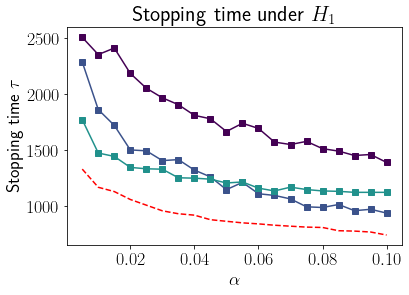

In [161]:
mpl.rcParams['font.size'] = 18
cm = plt.get_cmap('viridis') 
cmap = [cm(i) for i in np.linspace(0,1,5)]


plt_mean_std(plt, betting_results, alphas, None, color='red', plot_std=False, ls='--')
plt_mean_std(plt, perm_250_results, alphas, None, marker='s', color=cmap[0], plot_std=False)
plt_mean_std(plt, perm_500_results, alphas, None, marker='s', color=cmap[1], plot_std=False)
plt_mean_std(plt, perm_1000_results, alphas, None, marker='s', color=cmap[2], plot_std=False)


# plt.legend(fontsize=12)
plt.xlabel('$\\alpha$')
plt.ylabel('Stopping time $\\tau$')
plt.title('Stopping time under $H_1$')
plt.savefig('plots/credit_loan.png', dpi=300, bbox_inches='tight')

# Null

In [42]:
np.mean(y1), np.mean(y2)

(0.0394941971245453, 0.0721915285451197)

In [48]:
z1 = y1 + np.mean(y2) - np.mean(y1)
z2 = y2 
np.mean(z1), np.mean(z2)

(0.07219152854511969, 0.0721915285451197)

In [99]:
iters = 20

_, betting_rejects = betting_experiment(z1, z2, alphas, iters)
save_results('betting_rejects_loan', betting_rejects)
_, perm_250_rejects = seq_perm_test_experiment(z1, z2, alphas, iters, k=250, bonferroni=False)
save_results('perm_250_rejects_loan', perm_250_rejects)
_, perm_500_rejects = seq_perm_test_experiment(z1, z2, alphas, iters, k=500, bonferroni=False)
save_results('perm_500_rejects_loan', perm_500_rejects)
_, perm_1000_rejects = seq_perm_test_experiment(z1, z2, alphas, iters, k=1000, bonferroni=False)
save_results('perm_1000_rejects_loan', perm_1000_rejects)

In [169]:
# Reload if you've run the above experiment multiple times and have saved values 

betting_rejects = load_results('betting_rejects_loan')
perm_250_rejects = load_results('perm_250_rejects_loan')
perm_500_rejects = load_results('perm_500_rejects_loan')
perm_1000_rejects = load_results('perm_1000_rejects_loan')

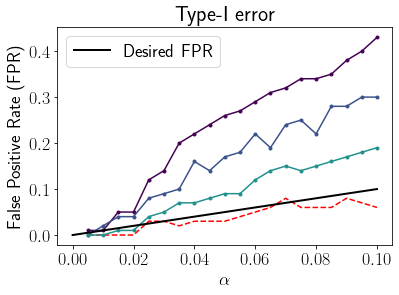

In [159]:
# mean = np.mean(betting_rejects, axis=0)
# plt.plot(alphas, mean)

plt_mean_std(plt, betting_rejects, alphas, None, color='red', ls='--', plot_std=False)
plt_mean_std(plt, perm_250_rejects, alphas, None, marker='.', color=cmap[0], plot_std=False)
plt_mean_std(plt, perm_500_rejects, alphas, None, marker='.', color=cmap[1], plot_std=False)
plt_mean_std(plt, perm_1000_rejects, alphas, None, marker='.', color=cmap[2], plot_std=False)
plt.plot([0, 0.1], [0, 0.1], color='k', lw=2, label='Desired FPR')
plt.xlabel('$\\alpha$')
plt.ylabel('False Positive Rate (FPR)')
plt.title('Type-I error')
plt.legend(fontsize=18, loc='upper left')
plt.savefig('plots/loan_fpr.png', dpi=300, bbox_inches='tight')

# FDR versus tau 

In [200]:
iters = 50 

# betting_times, _ = betting_experiment(y1, y2, alphas, iters)
perm_250_results, _ = seq_perm_test_experiment(y1, y2, alphas, iters, k=250, bonferroni=False)
save_results('perm_250_loan_tau', perm_250_results)
perm_500_results, _ = seq_perm_test_experiment(y1, y2, alphas, iters, k=500, bonferroni=False)
save_results('perm_500_loan_tau', perm_500_results)
perm_1000_results, _ = seq_perm_test_experiment(y1, y2, alphas, iters, k=1000, bonferroni=False)
save_results('perm_1000_loan_tau', perm_1000_results)

Text(0, 0.5, 'FPR under $H_0$')

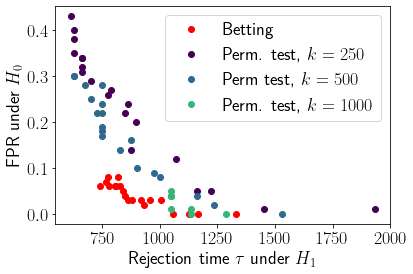

In [198]:
cm = plt.get_cmap('viridis') 
cmap = [cm(i) for i in np.linspace(0,1,4)]


plt.plot(np.mean(betting_results, axis=0), np.mean(betting_rejects, axis=0), 'o', c='red', label='Betting')
plt.plot(np.mean(perm_250_results, axis=0), np.mean(perm_250_rejects, axis=0), 'o', c=cmap[0], label='Perm. test, $k=250$')
plt.plot(np.mean(perm_500_results, axis=0), np.mean(perm_500_rejects, axis=0), 'o', c=cmap[1], label='Perm test, $k=500$')
# Remove pareto dominated points
inds = np.argsort(np.mean(perm_1000_rejects, axis=0))
plt.plot(np.mean(perm_1000_results, axis=0)[inds[:-14]], np.mean(perm_1000_rejects, axis=0)[inds[:-14]], 'o', c=cmap[2], label='Perm. test, $k=1000$')

plt.legend()
plt.xlabel('Rejection time $\\tau$ under $H_1$')
plt.ylabel('FPR under $H_0$')
    

# Distribution shift 

In [101]:
# Switch to another model halfway through 
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
y1_lr = lr.predict(X1)
y2_lr = lr.predict(X2)


/Users/benchugg/opt/anaconda3/envs/playground/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [210]:
pipe = make_pipeline(StandardScaler(), LogisticRegression(random_state=42))
pipe.fit(X_train, y_train)  # apply scaling on training data
y1_lr = pipe.predict(X1)
y2_lr = pipe.predict(X2)

In [105]:
np.mean(y1_lr), np.mean(y2_lr)

(0.015070154165944916, 0.03572744014732965)

In [118]:
shift_time = 400
seq1 = np.concatenate((z1[:shift_time], y1_lr[shift_time:]))
seq2 = np.concatenate((z2[:shift_time], y2_lr[shift_time:]))

In [148]:
iters = 20 

betting_shift, _ = betting_experiment(seq1, seq2, alphas, iters, shift_time=shift_time)
perm_250_shift, _ = seq_perm_test_experiment(seq1, seq2, alphas, iters, k=250, bonferroni=True, shift_time=shift_time)
perm_500_shift, _ = seq_perm_test_experiment(seq1, seq2, alphas, iters, k=500, bonferroni=True, shift_time=shift_time)
perm_1000_shift, _ = seq_perm_test_experiment(seq1, seq2, alphas, iters, k=1000, bonferroni=True, shift_time=shift_time)

save_results('betting_shift_loan', betting_shift)
save_results('perm_250_shift_loan', perm_250_shift)
save_results('perm_500_shift_loan', perm_500_shift)
save_results('perm_1000_shift_loan', perm_1000_shift)

In [149]:
betting_shift = load_results('betting_shift_loan')
perm_250_shift = load_results('perm_250_shift_loan')
perm_500_shift = load_results('perm_500_shift_loan')
perm_1000_shift = load_results('perm_1000_shift_loan')

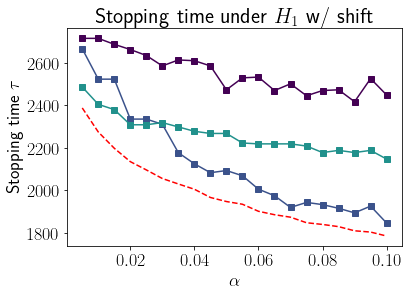

In [160]:
plt_mean_std(plt, betting_shift, alphas, None, color='red', ls='--', plot_std=False)
plt_mean_std(plt, perm_250_shift, alphas, None, color=cmap[0], marker='s', plot_std=False)
plt_mean_std(plt, perm_500_shift, alphas, None, color=cmap[1], marker='s', plot_std=False)
plt_mean_std(plt, perm_1000_shift, alphas, None, color=cmap[2], marker='s', plot_std=False)

# plt.legend()
plt.xlabel('$\\alpha$')
plt.ylabel('Stopping time $\\tau$')
plt.title('Stopping time under $H_1$ w/ shift')
plt.savefig('plots/loan_shift.png', dpi=300, bbox_inches='tight')

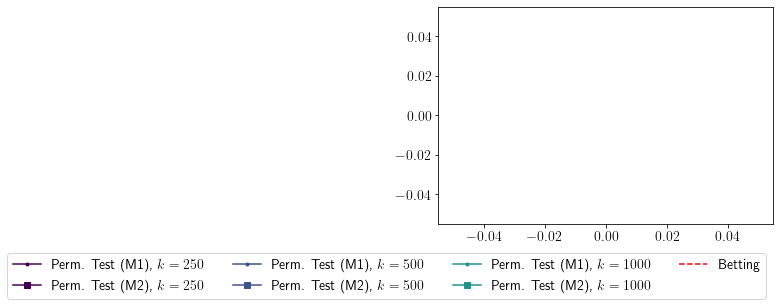

In [153]:
mpl.rcParams['text.usetex'] = True

plt.plot([], [], label='Perm. Test (M1), $k=250$', color=cmap[0], marker='.')
plt.plot([], [], label='Perm. Test (M2), $k=250$', color=cmap[0], marker='s')

plt.plot([], [], label='Perm. Test (M1), $k=500$', color=cmap[1], marker='.')
plt.plot([], [], label='Perm. Test (M2), $k=500$', color=cmap[1], marker='s')


plt.plot([], [], label='Perm. Test (M1), $k=1000$', color=cmap[2], marker='.')
plt.plot([], [], label='Perm. Test (M2), $k=1000$', color=cmap[2], marker='s')

plt.plot([], [], label='Betting', color='red', ls='--')

plt.legend(bbox_to_anchor=(1,-0.1), ncol=4)
plt.savefig('plots/legend.png', dpi=300, bbox_inches='tight', facecolor='white')